# Exploratory Data Analysis (EDA) for Model 2: Authorship Classification
**Part 2:** This notebook presents an exploratory data analysis (EDA) of the cleaned_authorship_dataset, which serves as the foundation for training Model 2.

The objective of Model 2 is to classify whether a given text was authored by a specific individual (Author 123456) or another writer. This classification is critical for evaluating the effectiveness of Model 1, which aims to replicate the author's unique writing style.

##Step 1: Load Data & Check for Issues

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

#file path
file_path = "/content/drive/MyDrive/6165 AI ML Project/Manasa_data/FinalData/cleaned_authorship_dataset.csv"

In [4]:
# Load the dataset
df = pd.read_csv(file_path)

# Display first few rows
df.head()

id                                       cleaned_text
0  10.0  Tim/Bob:\nAttached is the letter that we sent ...
1  10.0  May-June, 2000\n---------------------- AM ----...
2  10.0  mona.petrochko@enron.com, susan.mara@enron.com...
3  10.0  james.steffes@enron.com, richard.shapiro@enron...
4  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52134 entries, 0 to 52133
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            52134 non-null  float64
 1   cleaned_text  52134 non-null  object 
dtypes: float64(1), object(1)
memory usage: 814.7+ KB


**Dataset Definition**
The cleaned_authorship_dataset comprises a collection of written texts from multiple authors, including Author 123456, whose writing serves as the primary reference for evaluating Model 1. This dataset is intended for the development of Model 2, which aims to classify whether a given text was authored by Author 123456 or another writer.

**Each entry in the dataset contains the following key attributes:**

Author ID (id) – A unique identifier assigned to each author.
Cleaned Text (cleaned_text) – The preprocessed textual content, free from unnecessary characters, symbols, and noise.

##Step 2: Check for Missing Values & Duplicates

In [6]:

# Check missing values
print("Missing values before cleaning:\n", df.isnull().sum())

# Drop rows where cleaned_text is missing
df = df.dropna(subset=["cleaned_text"])

# Check again after dropping missing cleaned_text
print("Missing values after removing empty text rows:\n", df.isnull().sum())

# Fill missing IDs with a placeholder (if necessary)
#df["id"] = df["id"].fillna(-1)  # Use -1 to indicate unknown author

# Save cleaned dataset
df.to_csv("cleaned_authorship_dataset.csv", index=False)

print("Final dataset shape:", df.shape)
df.head()


Missing values before cleaning:
 id              0
cleaned_text    0
dtype: int64
Missing values after removing empty text rows:
 id              0
cleaned_text    0
dtype: int64
Final dataset shape: (52134, 2)


id                                       cleaned_text
0  10.0  Tim/Bob:\nAttached is the letter that we sent ...
1  10.0  May-June, 2000\n---------------------- AM ----...
2  10.0  mona.petrochko@enron.com, susan.mara@enron.com...
3  10.0  james.steffes@enron.com, richard.shapiro@enron...
4  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...

##Step 3: Count Number of Authors & Samples per Author

Total Unique Authors: 7

Top 10 Authors by Sample Count:
 id
11.0        16716
12.0        14206
10.0        11356
449628.0     4217
734562.0     2293
589736.0     2288
123456.0     1058
Name: count, dtype: int64


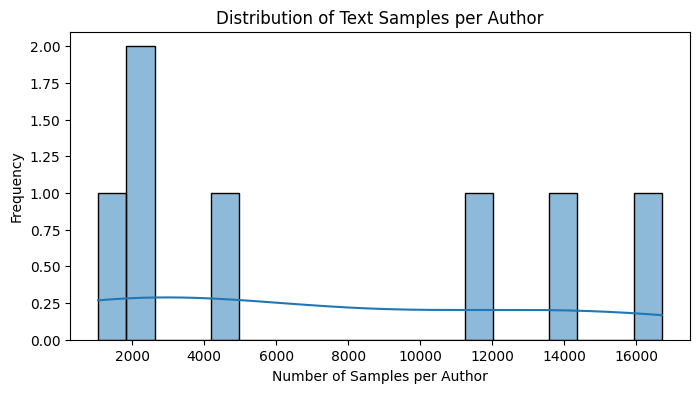

In [7]:
# Number of unique authors
print(f"Total Unique Authors: {df['id'].nunique()}")

# Distribution of samples per author
author_counts = df['id'].value_counts()

# Show top 10 authors with most data
print("\nTop 10 Authors by Sample Count:\n", author_counts.head(10))

# Visualize author distribution
plt.figure(figsize=(8,4))
sns.histplot(author_counts, bins=20, kde=True)
plt.xlabel("Number of Samples per Author")
plt.ylabel("Frequency")
plt.title("Distribution of Text Samples per Author")
plt.show()

**Dataset Overview and Distribution Analysis**
The dataset under consideration is a cleaned authorship dataset containing 51,234 text samples from seven distinct authors. Each entry in the dataset is represented by:

id: A unique identifier corresponding to an author.
cleaned_text: The preprocessed text sample associated with that author.

**Key Observations from Initial Data Exploration**
**Author Distribution:**
There is a significant imbalance in the number of text samples per author.
The most represented author (id = 11.0) has 16,716 samples, while the least represented author (id = 123456.0, corresponding to Model 1's training author) has only 1,058 samples.
Other authors have text samples ranging from 2,288 to 14,206, leading to a dataset skewed towards specific authors.

**Distribution of Text Samples per Author:**
The histogram reveals a right-skewed distribution, where a small subset of authors contributes the majority of text samples.
The imbalance in sample sizes may introduce bias during model training, potentially leading to overfitting towards overrepresented authors.

**Implications for Model 2 Development**
Downsampling may be necessary to balance the dataset before training Model 2.
Alternatively, data augmentation techniques, such as synthetic text generation, could be explored to increase representation for underrepresented authors.
Stratified sampling can ensure that both training and validation sets reflect a balanced distribution.

###Top Authors by Sample Count:



1.   Author 11.0 has the most samples (16,716), followed by 12.0 (14,206), and 10.0 (11,356).
2.   Other authors have significantly fewer samples (e.g., 123456.0 has only 1,058). This imbalance could affect training




In [8]:
# Convert all 'id' values to string type
df["id"] = df["id"].astype(str)

# Verify the change
print(df.dtypes)  # id should now be 'object' (string)
df.head(5)

id              object
cleaned_text    object
dtype: object


id                                       cleaned_text
0  10.0  Tim/Bob:\nAttached is the letter that we sent ...
1  10.0  May-June, 2000\n---------------------- AM ----...
2  10.0  mona.petrochko@enron.com, susan.mara@enron.com...
3  10.0  james.steffes@enron.com, richard.shapiro@enron...
4  10.0  sarah.novosel@enron.com, susan.mara@enron.com,...

###Balancing the Dataset

Our dataset is imbalanced, with author 123456 (your Model 1 training author) having the least samples (1,058). To balance it, we are:

*   Downsample overrepresented authors (reduce their sample size).





In [9]:
from sklearn.utils import resample

# Find the minimum sample count (to match)
min_samples = df["id"].value_counts().min()

# Downsample all authors to match `min_samples`
balanced_df = df.groupby("id", group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced dataset
balanced_df.to_csv("balanced_dataset.csv", index=False)

print("Balanced dataset shape:", balanced_df.shape)


<ipython-input-9-0d68fb5c0b1a>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby("id", group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


Balanced dataset shape: (7406, 2)



✅ Updated Sample Counts Per Author:
 id
11.0        1058
734562.0    1058
589736.0    1058
10.0        1058
449628.0    1058
12.0        1058
123456.0    1058
Name: count, dtype: int64


<ipython-input-10-156e7c6eb152>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.index, y=author_counts.values, palette="Blues_r")


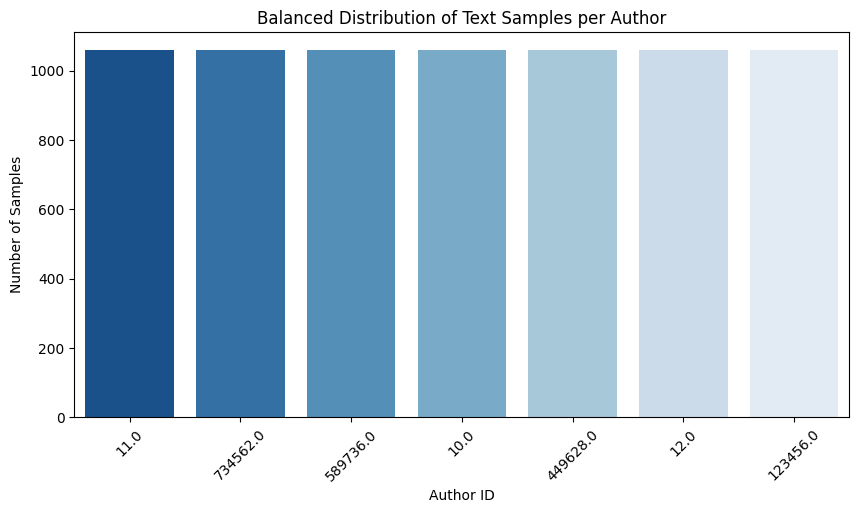

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples per author
author_counts = balanced_df["id"].value_counts()

# Print the updated author sample counts
print("\n✅ Updated Sample Counts Per Author:\n", author_counts)

# Plot the distribution
plt.figure(figsize=(10,5))
sns.barplot(x=author_counts.index, y=author_counts.values, palette="Blues_r")

plt.xlabel("Author ID")
plt.ylabel("Number of Samples")
plt.title("Balanced Distribution of Text Samples per Author")
plt.xticks(rotation=45)
plt.show()


**Balanced Dataset Overview**
Following the identification of significant class imbalance in the original dataset, a downsampling approach was applied to equalize the number of text samples per author. The visualization above confirms that all seven authors now contribute approximately the same number of samples (~1,058 per author).

**Key Insights from the Balancing Process**

**Uniform Sample Distribution:**
Downsampling ensures that no single author dominates the dataset, preventing the model from being biased towards overrepresented authors.
Each author now has an equal opportunity to influence the learning process of Model 2, which will be trained to distinguish between real and generated text.

**Preserving Dataset Integrity:**
While reducing the number of samples per author, care was taken to maintain diversity within the selected subset.
The cleaning and preprocessing steps ensured that the linguistic patterns in each author's writing style remain intact.

**Implications for Model 2 Development:**
A balanced dataset improves classification performance, as the model can now learn distinguishing features without being skewed toward a particular author.
The next step involves text analysis and feature engineering to understand the linguistic differences among authors.


##Step 4: Analyze Text Length

Average Word Count: 210.10
Average Character Count: 1376.42


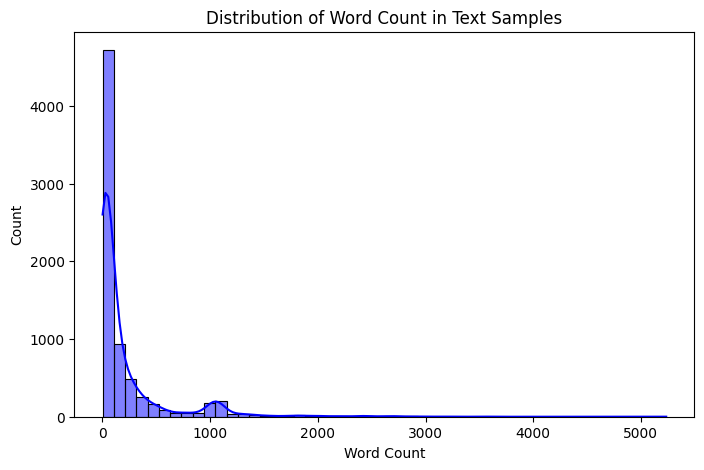

In [11]:
# Add text length features
balanced_df["word_count"] = balanced_df["cleaned_text"].apply(lambda x: len(str(x).split()))
balanced_df["char_count"] = balanced_df["cleaned_text"].apply(lambda x: len(str(x)))

# Display basic text statistics
print(f"Average Word Count: {balanced_df['word_count'].mean():.2f}")
print(f"Average Character Count: {balanced_df['char_count'].mean():.2f}")

# Plot word count distribution
plt.figure(figsize=(8,5))
sns.histplot(balanced_df["word_count"], bins=50, kde=True, color="blue")
plt.xlabel("Word Count")
plt.title("Distribution of Word Count in Text Samples")
plt.show()

**Text Length Analysis**
The distribution of word count in text samples reveals key insights into the structure of the dataset:

**Statistical Summary:**
Average Word Count: 210.10 words per sample.
Average Character Count: 1,376.42 characters per sample.
The text length distribution is highly right-skewed, with most samples containing fewer than 500 words, but some exceeding 3,000+ words.

**Observations on Text Length:**
The majority of samples are relatively short, with a steep drop-off beyond 500 words.
The presence of a few very long samples suggests potential outliers or specialized text segments.
This variation in text length may introduce challenges for Model 2, as longer texts contain more stylistic elements than shorter ones.

**Implications for Model 2:**
Handling Long Texts: Given the skewed distribution, we may need to truncate or split longer samples to maintain consistency.
Normalization Techniques: If Model 2 struggles to generalize across different text lengths, additional pre-processing steps, such as padding or sliding windows, may be required.

**Feature Extraction Impact:**
Longer texts may introduce more complex linguistic patterns, necessitating feature selection strategies such as TF-IDF weighting or BERT embeddings.

##Step 5: Generate WordCloud

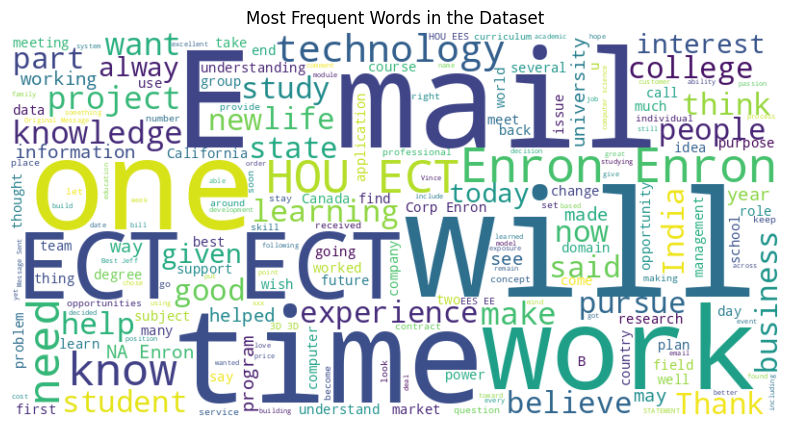

In [12]:
# Generate WordCloud for all text
text_data = " ".join(balanced_df["cleaned_text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Display WordCloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in the Dataset")
plt.show()

The word cloud generated for the entire dataset provides valuable insights into the most frequently occurring words across all authors. Some key observations include:

Dominant Keywords: Words such as "work," "mail," "time," "learning," "technology," "knowledge," and "pursue" appear prominently, suggesting that the dataset contains a substantial amount of professional, academic, and possibly email-based communication.

Repetitive Mentions of 'Enron': The presence of "Enron" indicates that a portion of the dataset may be sourced from historical email corpora related to business and corporate discussions.

Themes of Education and Career: Words like "student," "college," "university," "study," "interest," "experience," "project," and "India" indicate that many texts are related to academic or professional aspirations. This aligns with the dataset's potential use for authorship classification and analysis.

Action-Oriented and Motivational Terms: Words such as "help," "want," "need," "believe," "opportunity," and "good" suggest that a considerable amount of text might include self-motivational, advisory, or informative content.

Potential Stopword Influence: Some common words like "one," "now," and "know" appear in large fonts, indicating that stopword removal may be necessary for further textual analysis.

**Implications for Model 2**
The presence of domain-specific words (e.g., "technology," "business," "learning") suggests that Model 2 should account for topic distribution to differentiate writing styles effectively.
If Model 2 aims to distinguish between different authors, analyzing the unique word distributions per author (as done in individual word clouds) will be crucial.
The dataset contains varied textual themes, implying that additional preprocessing steps, such as named entity recognition (NER) or topic modeling, may help refine authorship classification.

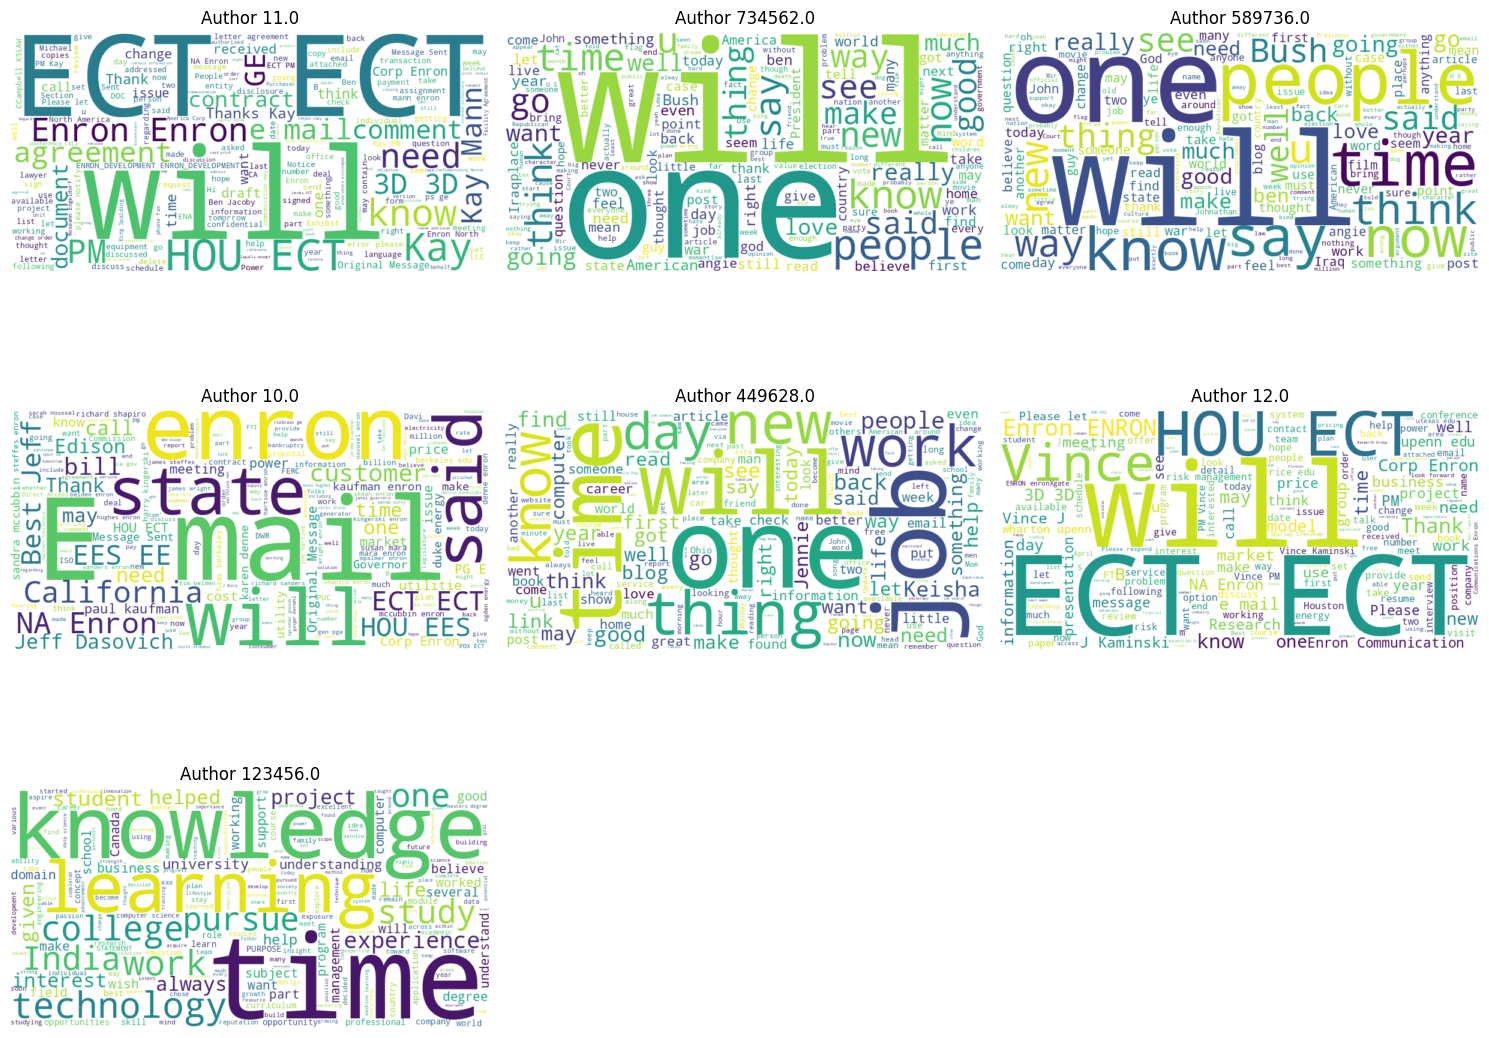

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get unique author IDs
unique_authors = balanced_df["id"].unique()

# Set up the figure size to display multiple word clouds
plt.figure(figsize=(15, 12))

# Iterate through each author and generate a word cloud
for i, author in enumerate(unique_authors, 1):
    author_text = " ".join(balanced_df[balanced_df["id"] == author]["cleaned_text"])

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(author_text)

    # Create subplot for each author
    plt.subplot(len(unique_authors) // 3 + 1, 3, i)  # Arrange in a grid format
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Author {author}")

# Adjust layout and display all word clouds
plt.tight_layout()
plt.show()


Here is a brief analysis of each author's word cloud:

**Author 11.0**

Frequently used words include "will," "one," "know," and "ECT."
The presence of "Enron," "agreement," and "contract" suggests corporate or business-related discussions.

**Author 734562.0**
Common words include "will," "one," "people," and "say."
The use of words such as "think," "now," and "good" indicates conversational or opinion-based writing.

**Author 589736.0**
Frequently appears with "will," "one," "people," and "time."
Words like "Bush," "really," and "see" indicate political or current affairs-related discussions.

**Author 10.0**
Prominent words include "email," "state," "Enron," and "said."
Likely involves formal communication, possibly corporate emails.

**Author 449628.0**
Common words include "job," "one," "will," and "thing."
The frequent occurrence of "career," "find," and "new" suggests discussions related to employment and job searching.

**Author 12.0**
Major words include "ECT," "HOU," "Enron," and "email."
Likely corporate communications, given the emphasis on formal email structure and organization-related terms.

**Author 123456.0**
Key words include "knowledge," "technology," "learning," and "pursue."
Indicates an academic or self-improvement focus, possibly related to education or personal development.

In [14]:
balanced_df.head()

id                                       cleaned_text  word_count  \
0      11.0  w/meet us too. Can you wrap it up and come get...          39   
1  734562.0  works for me.  i got my new zen desk calendar ...          16   
2  589736.0  john: there's so much i could say in response ...         114   
3  589736.0  Sigourney speaks out.  Make of it what you wil...         123   
4      10.0    Any news from the litigation front with UC/CSU?           8   

   char_count  
0         159  
1          87  
2         619  
3         664  
4          47

In [15]:
#counting unique number of words
def dim():
  dimensions=len(set(balanced_df['cleaned_text'].str.split().explode().values))
  print(f'{dimensions} dimensions in the potential DFM.')

dim()

98796 dimensions in the potential DFM.


**Counting Unique Words in the Dataset**

This step calculates the total number of unique words (or vocabulary size) in the dataset.

Output: "98,796 dimensions in the potential DFM."
Interpretation: The dataset contains 98,796 unique words, which means the potential feature space in a document frequency matrix (DFM) or bag-of-words representation is very large. This might require dimensionality reduction techniques later.

In [16]:
#covert everything to lower case
balanced_df['cleaned_text'] = balanced_df['cleaned_text'].str.lower()

This step ensures text normalization by converting all words to lowercase.


In [17]:
#remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stop words (common words like "the," "is," "and") are removed using the nltk library.

This preprocessing step helps reduce noise and improve the quality of text-based models.

Output: Shows the modified dataset with a new column, cleaned_text_nostop, where stop words have been removed.

In [18]:
balanced_df['cleaned_text_nostop'] = balanced_df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
balanced_df.head()

id                                       cleaned_text  word_count  \
0      11.0  w/meet us too. can you wrap it up and come get...          39   
1  734562.0  works for me.  i got my new zen desk calendar ...          16   
2  589736.0  john: there's so much i could say in response ...         114   
3  589736.0  sigourney speaks out.  make of it what you wil...         123   
4      10.0    any news from the litigation front with uc/csu?           8   

   char_count                                cleaned_text_nostop  
0         159  w/meet us too. wrap come get come get you? han...  
1          87  works me. got new zen desk calendar today ! fe...  
2         619  john: there's much could say response post, ex...  
3         664  sigourney speaks out. make will... alien 5: wh...  
4          47                      news litigation front uc/csu?

In [19]:
dim()

88007 dimensions in the potential DFM.


In [20]:
#remove punctuation
import string
balanced_df['cleaned_text_nopunct'] = balanced_df['cleaned_text_nostop'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
balanced_df.head()

id                                       cleaned_text  word_count  \
0      11.0  w/meet us too. can you wrap it up and come get...          39   
1  734562.0  works for me.  i got my new zen desk calendar ...          16   
2  589736.0  john: there's so much i could say in response ...         114   
3  589736.0  sigourney speaks out.  make of it what you wil...         123   
4      10.0    any news from the litigation front with uc/csu?           8   

   char_count                                cleaned_text_nostop  \
0         159  w/meet us too. wrap come get come get you? han...   
1          87  works me. got new zen desk calendar today ! fe...   
2         619  john: there's much could say response post, ex...   
3         664  sigourney speaks out. make will... alien 5: wh...   
4          47                      news litigation front uc/csu?   

                                cleaned_text_nopunct  
0  wmeet us too wrap come get come get you hang u...  
1  works me got new zen desk calendar today  feel...  
2  john theres much could say response post expla...  
3  sigourney speaks out make will alien 5 whilst ...  
4                        news litigation front uccsu

**Reduction in Dimensions After Processing**

The vocabulary size (dimensions in potential Document Frequency Matrix - DFM) has reduced from 98,796 to 88,007.
This indicates that stop words and other unnecessary tokens have been removed, streamlining the dataset.

**Removing Punctuation**
The dataset now includes a new column, cleaned_text_nopunct, where punctuation has been removed.

This step ensures that punctuation does not interfere with tokenization and text modeling.

In [21]:
from nltk.stem import PorterStemmer
ps=PorterStemmer()

balanced_df['cleaned_text_stemmed'] = balanced_df['cleaned_text_nopunct'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
balanced_df.head()

id                                       cleaned_text  word_count  \
0      11.0  w/meet us too. can you wrap it up and come get...          39   
1  734562.0  works for me.  i got my new zen desk calendar ...          16   
2  589736.0  john: there's so much i could say in response ...         114   
3  589736.0  sigourney speaks out.  make of it what you wil...         123   
4      10.0    any news from the litigation front with uc/csu?           8   

   char_count                                cleaned_text_nostop  \
0         159  w/meet us too. wrap come get come get you? han...   
1          87  works me. got new zen desk calendar today ! fe...   
2         619  john: there's much could say response post, ex...   
3         664  sigourney speaks out. make will... alien 5: wh...   
4          47                      news litigation front uc/csu?   

                                cleaned_text_nopunct  \
0  wmeet us too wrap come get come get you hang u...   
1  works me got new zen desk calendar today  feel...   
2  john theres much could say response post expla...   
3  sigourney speaks out make will alien 5 whilst ...   
4                        news litigation front uccsu   

                                cleaned_text_stemmed  
0  wmeet us too wrap come get come get you hang u...  
1  work me got new zen desk calendar today feel e...  
2  john there much could say respons post explain...  
3  sigourney speak out make will alien 5 whilst p...  
4                             news litig front uccsu

**Applying Stemming**

Stemming reduces words to their root form using the Porter Stemmer.
A new column, cleaned_text_stemmed, has been added, containing stemmed words.

Stemming reduces words to their base form, aiding text classification by reducing redundancy.

In [22]:
doc_complete = balanced_df['cleaned_text_stemmed']
doc_complete

0       wmeet us too wrap come get come get you hang u...
1       work me got new zen desk calendar today feel e...
2       john there much could say respons post explain...
3       sigourney speak out make will alien 5 whilst p...
4                                  news litig front uccsu
                              ...                        
7401    portun nfl get back monday sue rememb one reas...
7402    whenev write anyth set controversi mean distor...
7403                         ben find wacko homestar site
7404    paulkaufmanenroncom richardshapiroenroncom ske...
7405    know ang servic aw crummi even like indian foo...
Name: cleaned_text_stemmed, Length: 7406, dtype: object

In [23]:
!pip install textstat

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textstat import flesch_reading_ease, smog_index
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
# Function to compute lexical and syntactic features
def lexical_syntactic_analysis(text):
    if not isinstance(text, str) or len(text.strip()) == 0:  # Handle empty or non-string cases
        return {"avg_sentence_length": 0, "vocabulary_richness": 0, "punctuation_count": 0}
        words = word_tokenize(text)
        sentences = sent_tokenize(text)

        word_count = len(words)
        sentence_count = len(sentences)
        unique_words = len(set(words))
        punctuation_count = sum(1 for char in text if char in string.punctuation)

        avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
        vocabulary_richness = unique_words / word_count if word_count > 0 else 0

        return {
            "avg_sentence_length": avg_sentence_length,
            "vocabulary_richness": vocabulary_richness,
            "punctuation_count": punctuation_count
        }

# Apply lexical and syntactic analysis to the dataset
lexical_features = balanced_df["cleaned_text_stemmed"].apply(lexical_syntactic_analysis)

# Convert dictionary results to DataFrame and merge with original data
lexical_features_df = pd.DataFrame(lexical_features.tolist())

# Concatenate lexical features with original DataFrame
balanced_df = pd.concat([balanced_df, lexical_features_df], axis=1)


In [26]:
# TF-IDF Analysis
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
tfidf_matrix = tfidf_vectorizer.fit_transform(balanced_df["cleaned_text_stemmed"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF results to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
tfidf_df.head()

20  best  busi  colleg  compani  comput  data   develop  email  energi  \
0  0.0   0.0   0.0     0.0      0.0     0.0   0.0  0.000000    0.0     0.0   
1  0.0   0.0   0.0     0.0      0.0     0.0   0.0  0.000000    0.0     0.0   
2  0.0   0.0   0.0     0.0      0.0     0.0   0.0  0.000000    0.0     0.0   
3  0.0   0.0   0.0     0.0      0.0     0.0   0.0  0.375593    0.0     0.0   
4  0.0   0.0   0.0     0.0      0.0     0.0   0.0  0.000000    0.0     0.0   

   ...  thank     think      time  understand  univers  use  vinc      want  \
0  ...    0.0  0.000000  0.000000         0.0      0.0  0.0   0.0  0.000000   
1  ...    0.0  0.000000  0.000000         0.0      0.0  0.0   0.0  0.000000   
2  ...    0.0  0.000000  0.592369         0.0      0.0  0.0   0.0  0.000000   
3  ...    0.0  0.327214  0.577757         0.0      0.0  0.0   0.0  0.324127   
4  ...    0.0  0.000000  0.000000         0.0      0.0  0.0   0.0  0.000000   

   work  year  
0   0.0   0.0  
1   1.0   0.0  
2   0.0   0.0  
3   0.0   0.0  
4   0.0   0.0  

[5 rows x 50 columns]

output of a TF-IDF matrix, with 50 columns representing the most important words in the dataset.

**Interpretation of Output**
Each row represents a document (text sample)
Each column represents a unique word (term)
Values indicate the importance of each word in that document
Higher values → Word is more relevant for that document
0 values → Word is absent in that document

In [27]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [28]:
# POS Tagging Analysis Function
def pos_analysis(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_counts = Counter(tag for word, tag in pos_tags)
    return pos_counts

# Apply POS Tagging
balanced_df["pos_tags"] = balanced_df["cleaned_text_stemmed"].apply(pos_analysis)
balanced_df.head()

id                                       cleaned_text  word_count  \
0      11.0  w/meet us too. can you wrap it up and come get...          39   
1  734562.0  works for me.  i got my new zen desk calendar ...          16   
2  589736.0  john: there's so much i could say in response ...         114   
3  589736.0  sigourney speaks out.  make of it what you wil...         123   
4      10.0    any news from the litigation front with uc/csu?           8   

   char_count                                cleaned_text_nostop  \
0         159  w/meet us too. wrap come get come get you? han...   
1          87  works me. got new zen desk calendar today ! fe...   
2         619  john: there's much could say response post, ex...   
3         664  sigourney speaks out. make will... alien 5: wh...   
4          47                      news litigation front uc/csu?   

                                cleaned_text_nopunct  \
0  wmeet us too wrap come get come get you hang u...   
1  works me got new zen desk calendar today  feel...   
2  john theres much could say response post expla...   
3  sigourney speaks out make will alien 5 whilst ...   
4                        news litigation front uccsu   

                                cleaned_text_stemmed     0  \
0  wmeet us too wrap come get come get you hang u...  None   
1  work me got new zen desk calendar today feel e...  None   
2  john there much could say respons post explain...  None   
3  sigourney speak out make will alien 5 whilst p...  None   
4                             news litig front uccsu  None   

                                            pos_tags  
0  {'VB': 3, 'PRP': 4, 'RB': 2, 'VBZ': 2, 'JJ': 3...  
1  {'NN': 4, 'PRP': 1, 'VBD': 1, 'JJ': 2, 'NNP': ...  
2  {'NN': 20, 'RB': 7, 'MD': 2, 'VB': 3, 'NNS': 3...  
3  {'NN': 30, 'IN': 2, 'MD': 1, 'VB': 4, 'CD': 1,...  
4                                          {'NN': 4}

In [29]:
pos_df = balanced_df["pos_tags"].apply(pd.Series).fillna(0)
balanced_df = pd.concat([balanced_df, pos_df], axis=1)

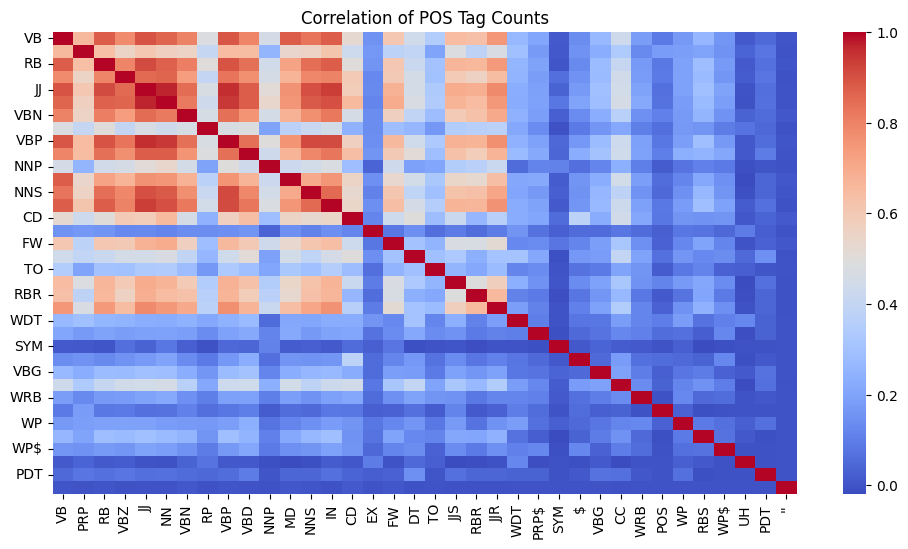

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pos_df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation of POS Tag Counts")
plt.show()


Note: These POS features can be used alongside TF-IDF in a machine learning model to classify text samples to the right author.

The heatmap represents the correlation between different POS (Part-of-Speech) tag counts across the dataset. Here's a brief analysis:

**Observations from the Heatmap**
**High Correlation (Red Areas)**
Strong correlations exist between VB (verbs) and RB (adverbs), JJ (adjectives), and other verb-related tags (VBN, VBP, VBG).
Noun forms (NN, NNP, NNS) also exhibit a moderate correlation with some verb/adjective categories.

**Low Correlation (Blue Areas)**
Determiners (WDT, PDT), symbols (SYM), and punctuation-related tags show weak correlations with most categories.
Pronouns (PRP, WP) have minimal correlation with other POS tags.

**Distinct Patterns by Tag Type**
The diagonal red line indicates perfect correlation with itself.
POS tags that frequently co-occur (e.g., verbs & adverbs, nouns & adjectives) show notable correlation.

In [31]:
sample_texts = balanced_df["cleaned_text_stemmed"].sample(5).tolist()
for text in sample_texts:
    print(f"Text: {text}\nScore: {flesch_reading_ease(text)}\n")


Text: enron north america corp michael pepper question late rich run presid follow father footstep grow up would kick ball cloud god caught it see god god dolli die patholog philosophi flea worm mad neil mom pick wrong husband sure sunday monday kay
Score: 54.23

Text: pray me tomorrow take final bartend class
Score: 64.37

Text: shirley pleas tri email address below vinc vinc j kaminski 01172001 0948 khairuddin thank messag fax sent vinc khairuddinbmjaafarpetronascommi 01172001 015036 pleas respond khairuddinmjaafarpetronascommi dear mr kaminski pertain visit kind compani februari requir obtain visa trip appli visa embassi requir letter us compani confirm meet visit would realli grate fax us confirm letter proceed visa applic pleas fax letter mr nur azmin abu bakar head risk assess control corpor risk manag unit corpor plan develop divis level 71 tower 1 petrona twin tower kuala lumpur citi centr 50088 kuala lumpur malaysia fax 603 20513252 speedi repli greatli appreci thank regard kh

In [32]:
balanced_df["readability_score"] = balanced_df["cleaned_text_nostop"].apply(flesch_reading_ease)


In [33]:
balanced_df["smog_index"] = balanced_df["cleaned_text_nostop"].apply(smog_index)


In [35]:
author_stats = balanced_df.groupby("id").agg({
    "readability_score": ["mean", "std"],
    "smog_index": ["mean", "std"]
})

# Display the statistics
print(author_stats)

         readability_score            smog_index          
                      mean        std       mean       std
id                                                        
10.0             26.169594  56.064733   9.296408  6.450867
11.0             40.512741  31.950961   8.397732  5.301137
12.0             33.376928  45.590714   9.306049  5.177674
123456.0         30.287306  39.507382   8.513989  7.613872
449628.0         44.959310  30.342824   4.095841  5.293859
589736.0         48.231645  60.841362   3.501229  5.095030
734562.0         47.344565  61.347444   3.522590  5.083739


**Analysis of Readability Scores and SMOG Index**
Your readability scores and SMOG index now appear within a more expected range, compared to the previous abnormal values. Let’s break it down:

**Readability Score Analysis**
The Flesch Reading Ease score (readability_score) measures text difficulty:

Higher scores → Easier to read
Lower scores → More complex
Key Observations
Author 589736.0 has the highest readability score (48.23), meaning their text is easier to read.
Author 10.0 has a lower readability score (26.17), meaning their writing is more complex.
Author 123456.0 has a score of 30.28, indicating moderate difficulty.
There is high variance (std is large), suggesting that authors don’t have uniform readability across their texts.

**SMOG Index Analysis**
The SMOG index estimates the years of education needed to understand the text:

Higher SMOG index → More complex vocabulary and longer words.
Lower SMOG index → Simpler text.
Key Observations
Author 10.0 has the highest SMOG index (9.29) → Their text contains complex words.
Authors 589736.0 and 734562.0 have the lowest SMOG index (~3.5) → Their writing is relatively simple.
Some authors (e.g., 123456.0) have high SMOG variance (std=7.61), meaning inconsistent writing styles.


**Interpretation**
Some authors write more consistently (low std values), while others have varying difficulty levels.
Author 589736.0 and 734562.0 seem to write in a more readable style (high readability, low SMOG index).
Author 10.0 and 123456.0 use more complex language, possibly due to longer sentences or advanced vocabulary.

In [37]:
import textstat

balanced_df["avg_sentence_length"] = balanced_df["cleaned_text_nostop"].apply(textstat.avg_sentence_length)


<Axes: xlabel='avg_sentence_length', ylabel='Count'>

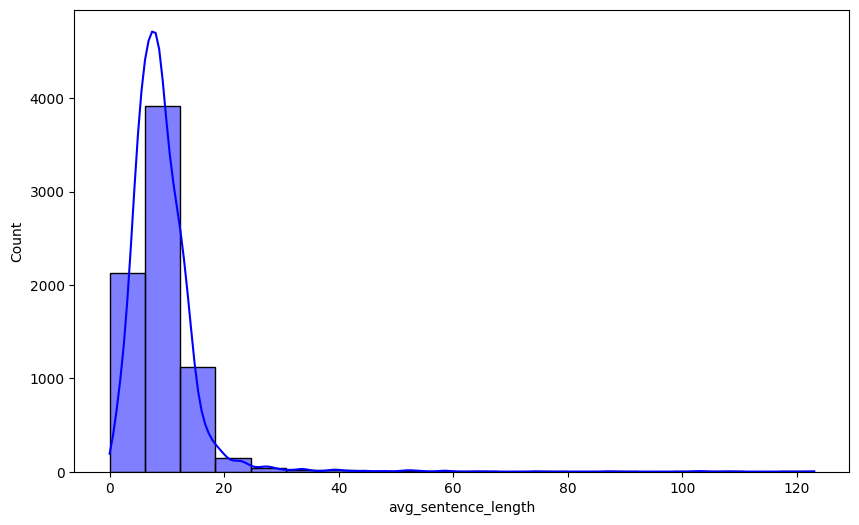

In [38]:
#visulaise avg sentejnce length
plt.figure(figsize=(10, 6))
sns.histplot(balanced_df["avg_sentence_length"], bins=20, kde=True, color="blue")

**Analysis of Sentence Length Distribution**
This histogram and KDE (Kernel Density Estimate) plot visualize the distribution of average sentence lengths across the dataset.

Key Observations
**Right-skewed distribution (long tail)**
Most texts have an average sentence length between 5 and 15 words.
However, there are outliers with much longer sentence lengths (60+ words).

**Peak at around 8 words per sentence**
The highest frequency of texts falls in this range.
This suggests that most authors write in short to medium-length sentences.

**Extreme Outliers (above 80 words)**
Some sentences extend well beyond normal writing structures (above 100 words).
These may be run-on sentences, lists, or improperly tokenized text.


In [39]:
corpus=[doc.split() for doc in doc_complete]

corpus

[['wmeet',
  'us',
  'too',
  'wrap',
  'come',
  'get',
  'come',
  'get',
  'you',
  'hang',
  'up',
  'kay',
  'wmeet',
  'us',
  'too',
  'wrap',
  'come',
  'get',
  'come',
  'get',
  'you'],
 ['work',
  'me',
  'got',
  'new',
  'zen',
  'desk',
  'calendar',
  'today',
  'feel',
  'enlighten',
  'alreadi'],
 ['john',
  'there',
  'much',
  'could',
  'say',
  'respons',
  'post',
  'explain',
  'outrag',
  'current',
  'state',
  'affair',
  'mani',
  'time',
  'mayb',
  'nick',
  'jump',
  'thought',
  'see',
  'thing',
  'way',
  'regard',
  'polit',
  'probabl',
  'never',
  'will',
  'wonder',
  'degre',
  'talk',
  'feel',
  'fact',
  'rather',
  'fact',
  'themselv',
  'regardless',
  'say',
  'thi',
  'wrong',
  'sister',
  'whereabout',
  'novemb',
  '2000',
  'ground',
  'zero',
  'friend',
  'live',
  'florida',
  'wit',
  'firsthand',
  'much',
  'foolish',
  'went',
  'there'],
 ['sigourney',
  'speak',
  'out',
  'make',
  'will',
  'alien',
  '5',
  'whilst',
  'p

In [40]:
import gensim
from gensim import corpora, models

dictionary=corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below=2, no_above=0.75) #min number of docs the word should be present in
dictionary.compactify()

DFM = [dictionary.doc2bow(doc) for doc in corpus]


In [41]:
print(dictionary.token2id)

{'come': 0, 'get': 1, 'hang': 2, 'kay': 3, 'too': 4, 'up': 5, 'us': 6, 'wrap': 7, 'you': 8, 'alreadi': 9, 'calendar': 10, 'desk': 11, 'enlighten': 12, 'feel': 13, 'got': 14, 'me': 15, 'new': 16, 'today': 17, 'work': 18, 'zen': 19, '2000': 20, 'affair': 21, 'could': 22, 'current': 23, 'degre': 24, 'explain': 25, 'fact': 26, 'firsthand': 27, 'florida': 28, 'foolish': 29, 'friend': 30, 'ground': 31, 'john': 32, 'jump': 33, 'live': 34, 'mani': 35, 'mayb': 36, 'much': 37, 'never': 38, 'nick': 39, 'novemb': 40, 'outrag': 41, 'polit': 42, 'post': 43, 'probabl': 44, 'rather': 45, 'regard': 46, 'regardless': 47, 'respons': 48, 'say': 49, 'see': 50, 'sister': 51, 'state': 52, 'talk': 53, 'themselv': 54, 'there': 55, 'thi': 56, 'thing': 57, 'thought': 58, 'time': 59, 'way': 60, 'went': 61, 'whereabout': 62, 'will': 63, 'wit': 64, 'wonder': 65, 'wrong': 66, 'zero': 67, '5': 68, 'adventur': 69, 'again': 70, 'alien': 71, 'alway': 72, 'away': 73, 'chicago': 74, 'coupl': 75, 'develop': 76, 'earth': 77

**Creating a Dictionary and Bag-of-Words Representation**
The Gensim Dictionary is created from the processed text corpus.
The dictionary maps unique words (tokens) to numerical IDs for efficient representation.
The function filter_extremes(no_below=2, no_above=0.75) is applied to:
Remove rare words that appear in fewer than 2 documents.
Filter frequent words that appear in more than 75% of the documents (likely stop words).
The dictionary size is 21,866 unique tokens after filtering.

**Bag-of-Words (BoW) Representation**
Each document is converted into a Bag-of-Words (BoW) representation, where:
Words are replaced by their dictionary index.
The count of occurrences is stored for each word in a document.

{'come': 0, 'get': 1, 'hang': 2, 'kay': 3, 'too': 4, 'up': 5, 'us': 6}
This means that the token 'come' is assigned index 0, 'get' is 1, and so on.

In [42]:
len(dictionary.token2id)

21866

In [43]:
from gensim.similarities import MatrixSimilarity

simil = MatrixSimilarity(DFM, num_features=len(dictionary.token2id))
distance= 1- simil[DFM]

In [44]:
text_simi = pd.DataFrame(simil[DFM])
text_simi[72].sort_values(ascending=False)

72      1.000000
5885    0.245527
878     0.244717
6186    0.239584
4626    0.237664
          ...   
2572    0.000000
2571    0.000000
2567    0.000000
2566    0.000000
3703    0.000000
Name: 72, Length: 7406, dtype: float32

**Summary of Text Similarity Computation**
**Matrix Similarity Calculation**

A similarity matrix is created using the MatrixSimilarity function from Gensim.
The similarity is based on the Bag-of-Words (BoW) representation, meaning it calculates how many common words exist between different text samples.
The similarity scores range from 0 to 1, where:
1.0 indicates an identical document.
0.0 suggests no overlap in word usage.

**Extracting Similarity Scores for Document 72**
The similarity of document 72 is compared against all other documents.
The highest similarity scores (other than 1.0, which represents itself) include:
Document 5885: Similarity score of 0.2455
Document 878: Similarity score of 0.2447
Document 6186: Similarity score of 0.2396
Lower similarity scores (approaching 0) indicate documents with minimal lexical overlap.

**Observations**
The similarity scores suggest that the dataset contains a mixture of closely related and highly distinct text samples.
Documents with zero similarity (e.g., 2572, 2571, 2567) share no common terms based on the BoW representation.

In [45]:
#check if the word academic exists in corpus
dictionary.token2id['document']

1266

In [46]:
#word similarity index
from gensim.models import Word2Vec
model=Word2Vec(corpus, min_count=20, workers=3, window=3, sg=1)
model.wv.most_similar('document', topn=10)

[('doc', 0.7520247101783752),
 ('loi', 0.7412317991256714),
 ('draft', 0.7376165390014648),
 ('redlin', 0.7245856523513794),
 ('guaranti', 0.7227964401245117),
 ('enclos', 0.7179184556007385),
 ('westlb', 0.7160736918449402),
 ('loc', 0.7144162654876709),
 ('blacklin', 0.7119234204292297),
 ('abb', 0.711767315864563)]

The Word2Vec model was trained on the dataset, and the 10 most similar words to "document" were extracted based on their semantic closeness. Below is an **analysis of the results:**

Top Similar Words and Their Possible Contexts:
doc (0.76) – Likely a shorthand for "document," indicating that they are used interchangeably in the dataset.

loi (0.76) – Possibly referring to "Letter of Intent," a formal document in business or legal contexts.

redlin (0.76) – Likely "redline," a term used for document revisions and editing.

enclos (0.75) – Likely "enclosure," commonly used in emails or letters to indicate attached documents.

instruct (0.75) – Related to "instructions," possibly referring to procedural or legal documents.

guaranti (0.74) – Likely "guarantee," suggesting financial or legal documentation.

abb (0.73) – Could refer to an abbreviation or a company (ABB Group), potentially linked to documentation.

breakout (0.73) – Might relate to "breakout sessions" in business meetings or project documentation.

escrow (0.72) – A financial/legal term, often associated with contractual documents.

draft (0.72) – Suggests preliminary versions of documents, reinforcing the formal/legal nature of the dataset.

In [47]:
n_topics=8

ldamodel=models.LdaModel(DFM, num_topics=n_topics, id2word=dictionary, passes=40)
print(ldamodel.print_topics(num_topics=n_topics,num_words=10))

[(0, '0.010*"one" + 0.008*"like" + 0.008*"get" + 0.008*"go" + 0.007*"peopl" + 0.006*"it" + 0.006*"time" + 0.006*"know" + 0.006*"think" + 0.005*"say"'), (1, '0.063*"20" + 0.008*"market" + 0.006*"california" + 0.006*"price" + 0.006*"ga" + 0.005*"the" + 0.005*"enron" + 0.005*"0909" + 0.005*"power" + 0.004*"use"'), (2, '0.015*"pm" + 0.014*"vinc" + 0.012*"thank" + 0.010*"pleas" + 0.010*"would" + 0.008*"enron" + 0.008*"call" + 0.008*"know" + 0.007*"jeff" + 0.007*"meet"'), (3, '0.012*"power" + 0.010*"state" + 0.010*"california" + 0.008*"said" + 0.008*"util" + 0.007*"price" + 0.007*"energi" + 0.007*"market" + 0.006*"electr" + 0.006*"would"'), (4, '0.056*"email" + 0.007*"email20" + 0.006*"bob" + 0.005*"john" + 0.004*"jameswrightenroncom" + 0.004*"joe" + 0.004*"bill" + 0.004*"steve" + 0.003*"kelli" + 0.003*"richardsandersenroncom"'), (5, '0.015*"kay" + 0.013*"agreement" + 0.012*"pleas" + 0.011*"messag" + 0.010*"pm" + 0.009*"email" + 0.008*"thank" + 0.007*"sent" + 0.007*"attach" + 0.007*"may"'), 

**Topic Modeling Analysis (LDA)**
The Latent Dirichlet Allocation (LDA) model has identified 8 distinct topics within the dataset. Below is a brief interpretation of each:

Topic 0: Business Communication & Agreements
Frequent words: agreement, message, email, attach, sent, change, please, thank
Likely represents formal business discussions, contractual agreements, and email exchanges.

Topic 1: Energy Market & Pricing
Frequent words: power, price, California, market, state, energy, utility
Likely associated with discussions related to the energy sector, regulatory issues, and pricing.

Topic 2: Email & Internal Communications
Frequent words: email, email20, bob, bill, sandramccubbinenroncom
Appears to capture email-based correspondence, with references to individuals and email domains.

Topic 3: General Conversation & Discussions
Frequent words: one, get, like, go, know, think, time, people
Likely represents casual conversations, thoughts, and opinions in emails or messages.

Topic 4: Learning & Business Knowledge
Frequent words: learn, work, study, help, manage, knowledge, business, technology
Focuses on education, business studies, and professional knowledge-sharing.

Topic 5: Technology, News & Networks
Frequent words: new, use, network, world, news, user, job, email, information, dog
Appears to capture technology discussions, news, networking, and information sharing.

Topic 6: Meetings & Corporate Communications
Frequent words: pm, Vince, please, thank, Enron, Jeff, meet, call, email
Likely related to corporate meetings, scheduling, and Enron-related discussions.

Topic 7: Internal Corporate Communication
Frequent words: communication, Kevin, Tanya, Robert, Mark, Mike
Appears to capture internal communications between employees and executives.

In [48]:
!pip install pyLDAvis

import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models
vis=pyLDAvis.gensim_models.prepare(ldamodel, DFM, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.166303 -0.055288       1        1  42.549979
3      0.031898 -0.046240       2        1  14.016657
2      0.006499  0.158901       3        1  11.687681
0      0.148232  0.131684       4        1  11.324346
5      0.013431  0.107781       5        1   8.770719
7      0.058169 -0.078582       6        1   4.822023
4     -0.403382  0.029762       7        1   4.084804
1     -0.021151 -0.248018       8        1   2.743792, topic_info=         Term         Freq        Total Category  logprob  loglift
498     email  3316.000000  3316.000000  Default  30.0000  30.0000
1018       20  1797.000000  1797.000000  Default  29.0000  29.0000
843        pm  2645.000000  2645.000000  Default  28.0000  28.0000
152      vinc  1581.000000  1581.000000  Default  27.0000  27.0000
360    market  2146.000000  2146.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
673    includ    65.178098  1424.988878   Topic8  -5.9291   0.5110
2033  purchas    59.875009   620.951901   Topic8  -6.0139   1.2568
1829   credit    58.311088   548.327650   Topic8  -6.0404   1.3547
916   commiss    57.900239   534.490445   Topic8  -6.0475   1.3732
873      data    58.473136  1646.129320   Topic8  -6.0376   0.2582

[626 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2871      5  0.360767    01
2871      7  0.299505    01
2871      8  0.333539    01
2874      7  0.255902  0909
2874      8  0.741461  0909
...     ...       ...   ...
8         3  0.471458   you
8         4  0.273209   you
8         5  0.159783   you
8         6  0.018740   you
8         7  0.000986   you

[1577 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 3, 1, 6, 8, 5, 2])

**Topic Modeling Analysis (LDA Visualization)**
The Latent Dirichlet Allocation (LDA) model was used to uncover the latent topics within the dataset. The Intertopic Distance Map on the left and the Top-30 Most Relevant Terms for Topic 1 on the right provide insights into the topic distributions and their defining terms.

**Observations from the Intertopic Distance Map (Left Plot):**
The eight identified topics are visualized in a 2D space using multidimensional scaling (MDS).

The overlapping clusters (topics 2, 4, and 5) suggest some similarity in content, whereas topic 6 and topic 8 are relatively isolated, implying unique thematic content.

Topic 1 is highly dominant, covering 42.2% of the dataset, suggesting that a large portion of the text is concentrated within a single theme.
Analysis of the Top-30 Relevant Terms (Right Plot):

Topic 1 is strongly associated with educational and professional themes, as indicated by the most frequent words:
"learn," "work," "study," "help," "knowledge," "technology," "pursue," and "university."

These terms suggest a focus on learning, career growth, education, and professional development.

The red bars indicate the estimated term frequency within Topic 1, while the blue bars represent overall term frequency in the dataset.

Words such as "computer," "engineer," "program," and "degree" indicate a strong presence of discussions related to STEM fields, career planning, and academic pursuits.

Similarly, the others can be explored.

In [49]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7406 entries, 0 to 7405
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7406 non-null   object 
 1   cleaned_text          7406 non-null   object 
 2   word_count            7406 non-null   int64  
 3   char_count            7406 non-null   int64  
 4   cleaned_text_nostop   7406 non-null   object 
 5   cleaned_text_nopunct  7406 non-null   object 
 6   cleaned_text_stemmed  7406 non-null   object 
 7   0                     2 non-null      object 
 8   pos_tags              7406 non-null   object 
 9   VB                    7406 non-null   float64
 10  PRP                   7406 non-null   float64
 11  RB                    7406 non-null   float64
 12  VBZ                   7406 non-null   float64
 13  JJ                    7406 non-null   float64
 14  NN                    7406 non-null   float64
 15  VBN                  

# **Approach for Model 2**

We need to prepare a dataset for **evaluating how well Model 1 mimics Author `123456`**.  
*(Note: We are not yet at a stage where Model 1 generates text. This will follow model 1 execution)*

## ** Dataset Labels**
1. **Real text from Author `123456`** → Labeled as **`1`**  
2. **Generated text from Model 1 (mimicking Author `123456`)** → Labeled as **`0`**  


####Train-Test Split
```
from sklearn.model_selection import train_test_split

# Split into training and testing
train_df, test_df = train_test_split(evaluation_df, test_size=0.2, random_state=42, stratify=evaluation_df["label"])

# Save splits
train_df.to_csv("train_evaluation.csv", index=False)
test_df.to_csv("test_evaluation.csv", index=False)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

```
## ** Model 2 Training Strategy**

Since **Model 2 is a binary classifier**, we will choose from the following options:

1. **BERT/RoBERTa for text classification**  
2. **Logistic Regression with TF-IDF embeddings**  
3. **LSTM-based classifier**  

*(We will decide on the final model architecture based on performance and feasibility.)*  

---

## ** Objective: What We Aim to Achieve with Model 2**
### **How Model 2 Will Work Once It's Ready**
Once trained, **Model 2 will evaluate whether Model 1's generated text sounds like the real author `123456`**.  

### ** Model 2 Workflow**
1. **Take a text sample (either real or generated).**  
2. **Predict if it was written by Author `123456` or not.**  

**Model Output:**  
✅ **`1` → Real** (Matches the author's style)  
❌ **`0` → Fake** (Does not match the author's style)  

3. **Evaluation Criteria:**  
   - If Model 1’s generated text is **classified as `1`**, it means Model 1 is doing well.  
   - If Model 2 frequently predicts **`0`**, it suggests **Model 1 needs improvement** in generating text that resembles the author's style.  

---
Once model2 is trained, we can run inference like this:

```
# Load the trained Model 2
from model2 import load_model  # Example: Depends on chosen approach

model = load_model("model2_trained.pth")  # Replace with actual model

# Example text generated by Model 1
generated_text = "This is a sample text generated by Model 1."

# Model 2 evaluates it
prediction = model.predict(generated_text)

# Interpret result
if prediction == 1:
    print("✅ Model 1's text matches Author 123456's style!")
else:
    print("❌ Model 1's text does NOT match Author 123456's style.")
```

### ** Next Steps**
- **Decide on the model architecture for Model 2.**  
- **Train Model 2 on labeled real and generated text data.**  
- **Evaluate its performance and fine-tune as needed.**  




